# Noise Comparison between exposures (20/09/2016)

In [1]:
import lsst.meas.astrom as measAstrom
import lsst.daf.base as dafBase
import lsst.pipe.base as pipeBase
import lsst.daf.persistence as dafPersist

import lsst.afw.display.ds9 as ds9
import DiaSourceTools as DSTools

import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom

import numpy as np


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
filter = 'i'
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")
visits = butler.queryMetadata("deepDiff_differenceExp", format=['visit', 'date'],dataId={'filter':filter})
ccds = butler.queryMetadata("deepDiff_differenceExp", format=['ccd'],dataId={'filter':filter})


In [13]:

def get_catalog(visit):
    visit_catalog = None

    for ccd in ccds:

            if butler.datasetExists("deepDiff_differenceExp", {'visit': visit , 'filter':filter , 'ccd':ccd}):

                diffExp = butler.get("deepDiff_differenceExp", {'visit': visit , 'filter':filter , 'ccd':ccd})
                diaSrcs = butler.get("deepDiff_diaSrc", {'visit': visit , 'filter':filter , 'ccd':ccd})
                #print "joining ccd "+ str(ccd) + " with " + str(len(diaSrcs)) + "sources"

                if visit_catalog == None:
                    visit_catalog = diaSrcs.copy()
                    visit_catalog.clear()
                else:
                    for source in diaSrcs:
                        visit_catalog.append(source)

    return visit_catalog

In [145]:
visit1 = 859604
#visit2 = 859605
#visit1 = 853733
visit2 = 853738




In [146]:
v_c1 = get_catalog(visit1)
v_c2 = get_catalog(visit2)
match = afwTable.matchRaDec(v_c1, v_c2, afwGeom.Angle(2./3600., afwGeom.degrees))
deltas = []
for m in match:
    s1 = m.first.get("base_CircularApertureFlux_6_0_fluxSigma")
    s2 = m.second.get("base_CircularApertureFlux_6_0_fluxSigma")
    f1 = m.first.get("base_CircularApertureFlux_6_0_flux")
    f2 = m.second.get("base_CircularApertureFlux_6_0_flux")
    sigma = np.sqrt(s1*s1+s2*s2)
    
    
    if np.isnan(s1)==False and np.isnan(s2)==False and np.isnan(f1)==False and np.isnan(f2)==False:
        deltas.append((f1-f2)/sigma)
        


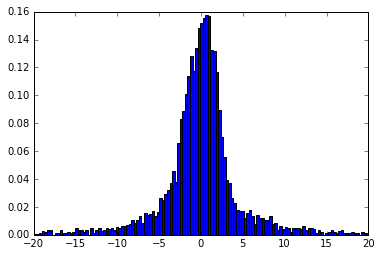

In [147]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab


%matplotlib inline

#n, bins, patches = plt.hist(deltas, bins=50, range=[-5, 5], normed=True, align='left')
n, bins, patches = plt.hist(deltas, bins=5000, normed=True, align='left')

bcenters = 0.5*(bins[1:]+bins[:-1])

mu = np.mean(deltas)

#sigma = 1

#x = np.linspace(min(deltas),max(deltas), 10000)
#plt.plot(x, mlab.normpdf(x,mu,sigma))
#plt.xlim(xmin=-20, xmax=20)

#sigma =1.6

#x = np.linspace(min(deltas),max(deltas), 10000)
#plt.plot(x, mlab.normpdf(x,mu,sigma))
plt.xlim(xmin=-20, xmax=20)

plt.show()

sigma value 2.13964131855
mean value 0.242699733836


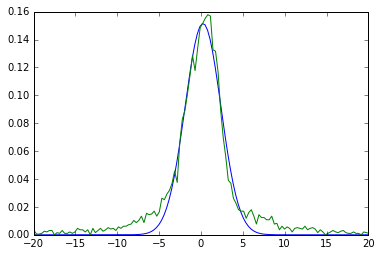

In [148]:
from scipy.optimize import curve_fit

def gaussian(x, am, mu, sigma):
    return am*np.exp(-(x-mu)**2/(2*sigma**2))


init_vals = [1, 0,1.0]
best_val, covar = curve_fit(gaussian, bcenters, n, p0=init_vals)
x = np.linspace(min(deltas),max(deltas), 5000)
plt.plot(x, gaussian(x, best_val[0], best_val[1], best_val[2]))
plt.xlim(xmin=-20, xmax=20)

plt.plot(bcenters, n)
print("sigma value "+str(best_val[-1]))
print("mean value "+str(best_val[1]))
plt.show()